<a href="https://colab.research.google.com/github/Park-YounHo/pytoch/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentencepiece
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 6.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=dd96ecd1479a44c0766f6ab2c4c04bd30fecdf86515b1a578d0ab71c8e1601d2
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/My Drive/transformer-evolution"

Mounted at /content/drive


In [3]:
import os
import gzip
import pandas as pd
import sentencepiece as spm
import shutil
import json
import wget
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm, tqdm_notebook, trange

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
for f in os.listdir(data_dir):
  print(f)

kowiki.model
kowiki.vocab
ratings_test.txt
ratings_train.txt
ratings_train.json
ratings_test.json
save_gpt_pretrain.pth
save_bert_pretrain.pth
kowiki_t5.vocab
kowiki_t5.model
save_t5_pretrain.pth
ratings_train_t5.json
ratings_test_t5.json


In [5]:
vocab_file = f"{data_dir}/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

lines = [
  "뭐 드시냐고 세번째 물어봅니다.",
  "배 먹어 배",
  "겨울 배가 맛있단다."
]
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  print(line)
  print(pieces)
  print(ids)
  print()

뭐 드시냐고 세번째 물어봅니다.
['▁', '뭐', '▁드', '시', '냐', '고', '▁세', '번째', '▁물', '어', '봅', '니다', '.']
[3587, 5593, 317, 3613, 4260, 3600, 73, 803, 289, 3624, 6177, 1234, 3590]

배 먹어 배
['▁배', '▁먹', '어', '▁배']
[179, 1135, 3624, 179]

겨울 배가 맛있단다.
['▁겨울', '▁배', '가', '▁', '맛', '있', '단', '다', '.']
[3091, 179, 3599, 3587, 4515, 3625, 3728, 3589, 3590]



In [6]:
vocab_file = f"{data_dir}/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

In [7]:
filename = wget.download("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", f"{data_dir}")
print(filename)
filename = wget.download("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", f"{data_dir}")
print(filename)
for f in os.listdir(data_dir):
  print(f)

/content/drive/My Drive/transformer-evolution/ratings_train (1).txt
/content/drive/My Drive/transformer-evolution/ratings_test (1).txt
kowiki.model
kowiki.vocab
ratings_test.txt
ratings_train.txt
ratings_train.json
ratings_test.json
save_gpt_pretrain.pth
save_bert_pretrain.pth
kowiki_t5.vocab
kowiki_t5.model
save_t5_pretrain.pth
ratings_train_t5.json
ratings_test_t5.json
ratings_train (1).txt
ratings_test (1).txt


In [8]:
def prepare_train(vocab, infile, outfile):
    df = pd.read_csv(infile, sep="\t", engine="python")
    with open(outfile, "w") as f:
        for index, row in df.iterrows():
            document = row["document"]
            if type(document) != str:
                continue
            instance = { "id": row["id"], "doc": vocab.encode_as_pieces(document), "label": row["label"] }
            f.write(json.dumps(instance))
            f.write("\n")

In [9]:
prepare_train(vocab, f"{data_dir}/ratings_train.txt", f"{data_dir}/ratings_train.json")
prepare_train(vocab, f"{data_dir}/ratings_test.txt", f"{data_dir}/ratings_test.json")
for f in os.listdir(data_dir):
  print(f)

kowiki.model
kowiki.vocab
ratings_test.txt
ratings_train.txt
ratings_train.json
ratings_test.json
save_gpt_pretrain.pth
save_bert_pretrain.pth
kowiki_t5.vocab
kowiki_t5.model
save_t5_pretrain.pth
ratings_train_t5.json
ratings_test_t5.json
ratings_train (1).txt
ratings_test (1).txt


In [10]:
vocab_file = f"{data_dir}/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

lines = [
  "뭐 드시냐고 세번째 물어봅니다.",
  "겨울 배가 맛있단다."
]

inputs = []
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  inputs.append(torch.tensor(ids))
  print(pieces)

inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
print(inputs.size())
print(inputs)

['▁', '뭐', '▁드', '시', '냐', '고', '▁세', '번째', '▁물', '어', '봅', '니다', '.']
['▁겨울', '▁배', '가', '▁', '맛', '있', '단', '다', '.']
torch.Size([2, 13])
tensor([[3587, 5593,  317, 3613, 4260, 3600,   73,  803,  289, 3624, 6177, 1234,
         3590],
        [3091,  179, 3599, 3587, 4515, 3625, 3728, 3589, 3590,    0,    0,    0,
            0]])


In [11]:
n_vocab = len(vocab)
d_hidn = 128 
nn_emb = nn.Embedding(n_vocab, d_hidn)

input_embs = nn_emb(inputs)
print(input_embs.size())

torch.Size([2, 13, 128])


In [12]:
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2]) 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) 

    return sinusoid_table

(64, 128)


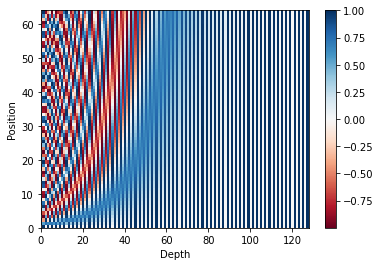

In [13]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print (pos_encoding.shape)
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [14]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions)

print(inputs)
print(positions)
print(pos_embs.size())

tensor([[3587, 5593,  317, 3613, 4260, 3600,   73,  803,  289, 3624, 6177, 1234,
         3590],
        [3091,  179, 3599, 3587, 4515, 3625, 3728, 3589, 3590,    0,    0,    0,
            0]])
tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  0,  0,  0]])
torch.Size([2, 13, 128])


In [15]:
input_sums = input_embs + pos_embs

In [16]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

torch.Size([2, 13, 13])
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, F

In [17]:
scores = torch.matmul(Q, K.transpose(-1, -2))
print(scores.size())
print(scores[0])

torch.Size([2, 13, 13])
tensor([[176.1648,  48.6844,  70.5019,  64.3945,  48.5610,  37.7630,  41.4303,
          61.1659,  53.7995,  55.5978,  52.3172,  57.6874,  44.2241],
        [ 48.6844, 169.1241,  49.1987,  62.1334,  44.3410,  18.1883,  26.8905,
          27.8159,  46.1319,  53.6875,  29.9415,  49.1539,  43.7460],
        [ 70.5019,  49.1987, 178.6357,  71.4453,  72.5604,  60.8030,  57.8270,
          52.0957,  56.1808,  46.9027,  47.6928,  33.7638,  32.6347],
        [ 64.3945,  62.1334,  71.4453, 194.6364,  76.7519,  91.5132,  72.1419,
          53.4698,  48.3907,  51.9957,  36.9210,  40.3156,  33.7999],
        [ 48.5610,  44.3410,  72.5604,  76.7519, 230.6856,  55.1407,  72.3932,
          77.4295,  61.8555,  43.6298,  36.5844,  43.8848,  68.1691],
        [ 37.7630,  18.1883,  60.8030,  91.5132,  55.1407, 196.9226,  65.0559,
          46.5306,  49.8374,  32.1155,  28.0407,  59.3799,  42.5054],
        [ 41.4303,  26.8905,  57.8270,  72.1419,  72.3932,  65.0559, 191.8319,
   

In [18]:
d_head = 64
scores = scores.mul_(1/d_head**0.5)
print(scores.size())
print(scores[0])

torch.Size([2, 13, 13])
tensor([[22.0206,  6.0856,  8.8127,  8.0493,  6.0701,  4.7204,  5.1788,  7.6457,
          6.7249,  6.9497,  6.5396,  7.2109,  5.5280],
        [ 6.0856, 21.1405,  6.1498,  7.7667,  5.5426,  2.2735,  3.3613,  3.4770,
          5.7665,  6.7109,  3.7427,  6.1442,  5.4683],
        [ 8.8127,  6.1498, 22.3295,  8.9307,  9.0700,  7.6004,  7.2284,  6.5120,
          7.0226,  5.8628,  5.9616,  4.2205,  4.0793],
        [ 8.0493,  7.7667,  8.9307, 24.3295,  9.5940, 11.4392,  9.0177,  6.6837,
          6.0488,  6.4995,  4.6151,  5.0395,  4.2250],
        [ 6.0701,  5.5426,  9.0700,  9.5940, 28.8357,  6.8926,  9.0492,  9.6787,
          7.7319,  5.4537,  4.5730,  5.4856,  8.5211],
        [ 4.7204,  2.2735,  7.6004, 11.4392,  6.8926, 24.6153,  8.1320,  5.8163,
          6.2297,  4.0144,  3.5051,  7.4225,  5.3132],
        [ 5.1788,  3.3613,  7.2284,  9.0177,  9.0492,  8.1320, 23.9790,  7.7992,
          3.3957,  4.6708,  2.5303,  3.3189,  4.1016],
        [ 7.6457,  3.477

In [19]:
scores.masked_fill_(attn_mask, -1e9)
print(scores.size())
print(scores[0])

torch.Size([2, 13, 13])
tensor([[22.0206,  6.0856,  8.8127,  8.0493,  6.0701,  4.7204,  5.1788,  7.6457,
          6.7249,  6.9497,  6.5396,  7.2109,  5.5280],
        [ 6.0856, 21.1405,  6.1498,  7.7667,  5.5426,  2.2735,  3.3613,  3.4770,
          5.7665,  6.7109,  3.7427,  6.1442,  5.4683],
        [ 8.8127,  6.1498, 22.3295,  8.9307,  9.0700,  7.6004,  7.2284,  6.5120,
          7.0226,  5.8628,  5.9616,  4.2205,  4.0793],
        [ 8.0493,  7.7667,  8.9307, 24.3295,  9.5940, 11.4392,  9.0177,  6.6837,
          6.0488,  6.4995,  4.6151,  5.0395,  4.2250],
        [ 6.0701,  5.5426,  9.0700,  9.5940, 28.8357,  6.8926,  9.0492,  9.6787,
          7.7319,  5.4537,  4.5730,  5.4856,  8.5211],
        [ 4.7204,  2.2735,  7.6004, 11.4392,  6.8926, 24.6153,  8.1320,  5.8163,
          6.2297,  4.0144,  3.5051,  7.4225,  5.3132],
        [ 5.1788,  3.3613,  7.2284,  9.0177,  9.0492,  8.1320, 23.9790,  7.7992,
          3.3957,  4.6708,  2.5303,  3.3189,  4.1016],
        [ 7.6457,  3.477

In [20]:
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[0])

torch.Size([2, 13, 13])
tensor([[1.0000e+00, 1.2009e-07, 1.8361e-06, 8.5574e-07, 1.1825e-07, 3.0662e-08,
         4.8494e-08, 5.7157e-07, 2.2760e-07, 2.8497e-07, 1.8911e-07, 3.7003e-07,
         6.8764e-08],
        [2.8954e-07, 1.0000e+00, 3.0877e-07, 1.5553e-06, 1.6824e-07, 6.3999e-09,
         1.8993e-08, 2.1322e-08, 2.1045e-07, 5.4115e-07, 2.7811e-08, 3.0704e-07,
         1.5618e-07],
        [1.3482e-06, 9.4033e-08, 9.9999e-01, 1.5170e-06, 1.7438e-06, 4.0109e-07,
         2.7649e-07, 1.3507e-07, 2.2507e-07, 7.0573e-08, 7.7898e-08, 1.3657e-08,
         1.1860e-08],
        [8.5031e-08, 6.4096e-08, 2.0528e-07, 1.0000e+00, 3.9850e-07, 2.5221e-06,
         2.2396e-07, 2.1703e-08, 1.1502e-08, 1.8050e-08, 2.7424e-09, 4.1919e-09,
         1.8565e-09],
        [1.2973e-10, 7.6550e-11, 2.6055e-09, 4.3998e-09, 1.0000e+00, 2.9528e-10,
         2.5516e-09, 4.7887e-09, 6.8352e-10, 7.0038e-11, 2.9031e-11, 7.2306e-11,
         1.5049e-09],
        [2.2895e-09, 1.9819e-10, 4.0785e-08, 1.8952e-06,

In [21]:
context = torch.matmul(attn_prob, V)
print(context.size())

torch.Size([2, 13, 128])


In [22]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        attn_prob = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn_prob, V)
        return context, attn_prob

In [23]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 2

In [24]:
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

q_s = W_Q(Q)
print(q_s.size())
q_s = q_s.view(batch_size, -1, n_head, d_head)
print(q_s.size())
q_s = q_s.transpose(1,2)
print(q_s.size())

torch.Size([2, 13, 128])
torch.Size([2, 13, 2, 64])
torch.Size([2, 2, 13, 64])


In [25]:
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 2, 13, 64]) torch.Size([2, 2, 13, 64]) torch.Size([2, 2, 13, 64])


In [26]:
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 13, 13])
torch.Size([2, 2, 13, 13])


In [27]:
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 13, 64])
torch.Size([2, 2, 13, 13])


In [28]:
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head)
print(context.size())

torch.Size([2, 13, 128])


In [29]:
linear = nn.Linear(n_head * d_head, d_hidn)
output = linear(context)
print(output.size())

torch.Size([2, 13, 128])


In [30]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        output = self.linear(context)
        return output, attn_prob

In [31]:
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1)
    return subsequent_mask


Q = input_sums
K = input_sums
V = input_sums

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_pad_mask[0])
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask[0])
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[0])

batch_size = Q.size(0)
n_head = 2

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [F

In [32]:
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([2, 13, 128]) torch.Size([2, 2, 13, 13])


In [33]:
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn * 4, kernel_size=1)
ff_1 = conv1(output.transpose(1, 2))
print(ff_1.size())

torch.Size([2, 512, 13])


In [34]:
active = F.gelu
ff_2 = active(ff_1)

In [35]:
conv2 = nn.Conv1d(in_channels=d_hidn * 4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1, 2)
print(ff_3.size())

torch.Size([2, 13, 128])


In [36]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        return output

In [37]:
vocab_file = f"{data_dir}/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

In [38]:
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [39]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_dec_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


In [40]:
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [41]:
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad).unsqueeze(1).expand(batch_size, len_q, len_k)  # <pad>
    return pad_attn_mask

In [42]:
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1)
    return subsequent_mask

In [43]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        context = torch.matmul(attn_prob, V)
        return context, attn_prob

In [44]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        output = self.linear(context)
        output = self.dropout(output)
        return output, attn_prob

In [45]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        return output

In [46]:
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, inputs, attn_mask):
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        att_outputs = self.layer_norm1(inputs + att_outputs)
        ffn_outputs = self.pos_ffn(att_outputs)
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs)
        return ffn_outputs, attn_prob

In [47]:
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, inputs):
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        outputs = self.enc_emb(inputs) + self.pos_emb(positions)

        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)

        attn_probs = []
        for layer in self.layers:
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        return outputs, attn_probs

In [48]:
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs)
        ffn_outputs = self.pos_ffn(dec_enc_att_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + ffn_outputs)
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob

In [49]:
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
    
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad)

        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

In [50]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
    
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs)
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

In [51]:
class MovieClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = Transformer(self.config)
        self.projection = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)
    
    def forward(self, enc_inputs, dec_inputs):
        dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs = self.transformer(enc_inputs, dec_inputs)
        dec_outputs, _ = torch.max(dec_outputs, dim=1)
        logits = self.projection(dec_outputs)
        return logits, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

In [52]:
class MovieDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                data = json.loads(line)
                self.labels.append(data["label"])
                self.sentences.append([vocab.piece_to_id(p) for p in data["doc"]])
    
    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]),
                torch.tensor([self.vocab.piece_to_id("[BOS]")]))

In [53]:
def movie_collate_fn(inputs):
    labels, enc_inputs, dec_inputs = list(zip(*inputs))

    enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0)
    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels, dim=0),
        enc_inputs,
        dec_inputs,
    ]
    return batch

In [54]:
batch_size = 128
train_dataset = MovieDataSet(vocab, f"{data_dir}/ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=movie_collate_fn)
test_dataset = MovieDataSet(vocab, f"{data_dir}/ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=movie_collate_fn)

Loading /content/drive/My Drive/transformer-evolution/ratings_train.json: 100%|██████████| 149995/149995 [00:04<00:00, 30234.62 lines/s]
Loading /content/drive/My Drive/transformer-evolution/ratings_test.json: 100%|██████████| 49997/49997 [00:01<00:00, 33078.10 lines/s]


In [55]:
def eval_epoch(config, model, data_loader):
    matchs = []
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm_notebook(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]
            _, indices = logits.max(1)

            match = torch.eq(indices, labels).detach()
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0


In [56]:
def train_epoch(config, epoch, model, criterion, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm_notebook(total=len(train_loader), desc=f"Train {epoch}") as pbar:
        for i, value in enumerate(train_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]

            loss = criterion(logits, labels)
            loss_val = loss.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [57]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.n_output = 2
print(config)

learning_rate = 5e-5
n_epoch = 10

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda'), 'n_output': 2}


In [58]:
model = MovieClassification(config)
model.to(config.device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_epoch, best_loss, best_score = 0, 0, 0
losses, scores = [], []
for epoch in range(n_epoch):
    loss = train_epoch(config, epoch, model, criterion, optimizer, train_loader)
    score = eval_epoch(config, model, test_loader)

    losses.append(loss)
    scores.append(score)

    if best_score < score:
        best_epoch, best_loss, best_score = epoch, loss, score
print(f">>>> epoch={best_epoch}, loss={best_loss:.5f}, socre={best_score:.5f}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Train 0:   0%|          | 0/1172 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Valid:   0%|          | 0/391 [00:00<?, ?it/s]

Train 1:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

Train 2:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

Train 3:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

Train 4:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

Train 5:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

Train 6:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

Train 7:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

Train 8:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

Train 9:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

>>>> epoch=9, loss=0.22613, socre=0.83673


,loss,score
0,0.483677,0.803368
1,0.402833,0.802988
2,0.374996,0.822089
3,0.355090,0.821669
4,0.335365,0.827810
5,0.314469,0.833510
6,0.292856,0.831610
7,0.270623,0.831210
8,0.247849,0.827810
9,0.226128,0.836730


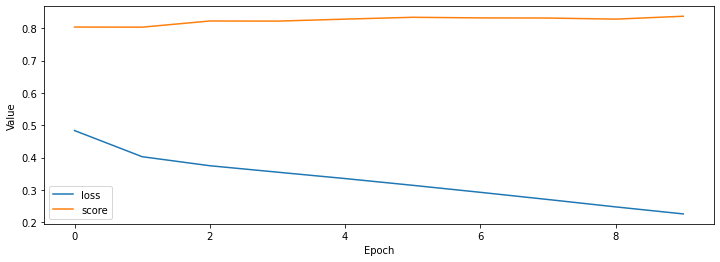

In [59]:
data = {
    "loss": losses,
    "score": scores
}
df = pd.DataFrame(data)
display(df)

plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.plot(scores, label="score")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()